# 基础设置

In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# setting params
params = ({'legend.fontsize':'x-large',
         'figure.figsize':(30,10),
         'axes.labelsize':'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.sans-serif':'SimHei',
         'axes.unicode_minus':False})

sns.set_style('whitegrid')
sns.set_context('talk')

plt.rcParams.update(params)
pd.options.display.max_colwidth = 600

# 加载数据

In [304]:
data = pd.read_csv(r"D:\BaiduNetdiskDownload\机器学习实战\baojie.csv",header = 0)
del(data['Unnamed: 0'])
data.head()

,revenue,reach,local_tv,online,instore,person,event
0,45860.28,2,31694.91,2115,3296,8,non_event
1,63588.23,2,35040.17,1826,2501,14,special
2,23272.69,4,30992.82,1851,2524,6,special
3,45911.23,2,29417.78,2437,3049,12,special
4,36644.23,2,35611.11,1122,1142,13,cobranding


## 数据说明

* Revenue 门店销售额
* Reach 微信推送次数
* Loval_tv 本地电视广告投入
* Online 线上广告投入
* Instore 门店内海报陈列等投入
* Person 门店销售人员投入
* Event 门店促销事件（cobranding 品牌联合促销 holiday 节假日 special 门店特别促销 non-event 无促销活动）

## 问题描述

对于快消品企业，能够对商超门店的销售额进行精准预测，尤其是能量化自身所能控制的各种促销因素产生的结果，是重要的数据应用

# 探索数据

## 数据基本情况

### 缺失值、数值类型

In [305]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   revenue   985 non-null    float64
 1   reach     985 non-null    int64  
 2   local_tv  929 non-null    float64
 3   online    985 non-null    int64  
 4   instore   985 non-null    int64  
 5   person    985 non-null    int64  
 6   event     985 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 54.0+ KB


#### 发现1

1. 特征<span class="girk">**local_tv**</span>存在<span class="girk">**缺失值**</span>，待后续处理。
2. 类别型特征只有<span class="girk">**event**</span>一个，该特征后续需要进行<span class="girk">**独热编码**</span>。

### 数据分布特征

In [306]:
data.describe()

,revenue,reach,local_tv,online,instore,person
count,985.000000,985.000000,929.000000,985.000000,985.000000,985.000000
mean,38357.355025,3.395939,31324.061109,1596.527919,3350.962437,11.053807
std,11675.603883,1.011913,3970.934733,496.131586,976.546381,3.041740
min,5000.000000,0.000000,20000.000000,0.000000,0.000000,0.000000
25%,30223.600000,3.000000,28733.830000,1253.000000,2690.000000,9.000000
50%,38159.110000,3.000000,31104.520000,1607.000000,3351.000000,11.000000
75%,45826.520000,4.000000,33972.410000,1921.000000,4011.000000,13.000000
max,79342.070000,7.000000,43676.900000,3280.000000,6489.000000,24.000000


#### 发现2

数据整体**<span class="girk">不存在明显有偏</span>**的情况，但仍需做**<span class="girk">标准化处理</span>**。

## 各种促销事件对应的门店销售额均值

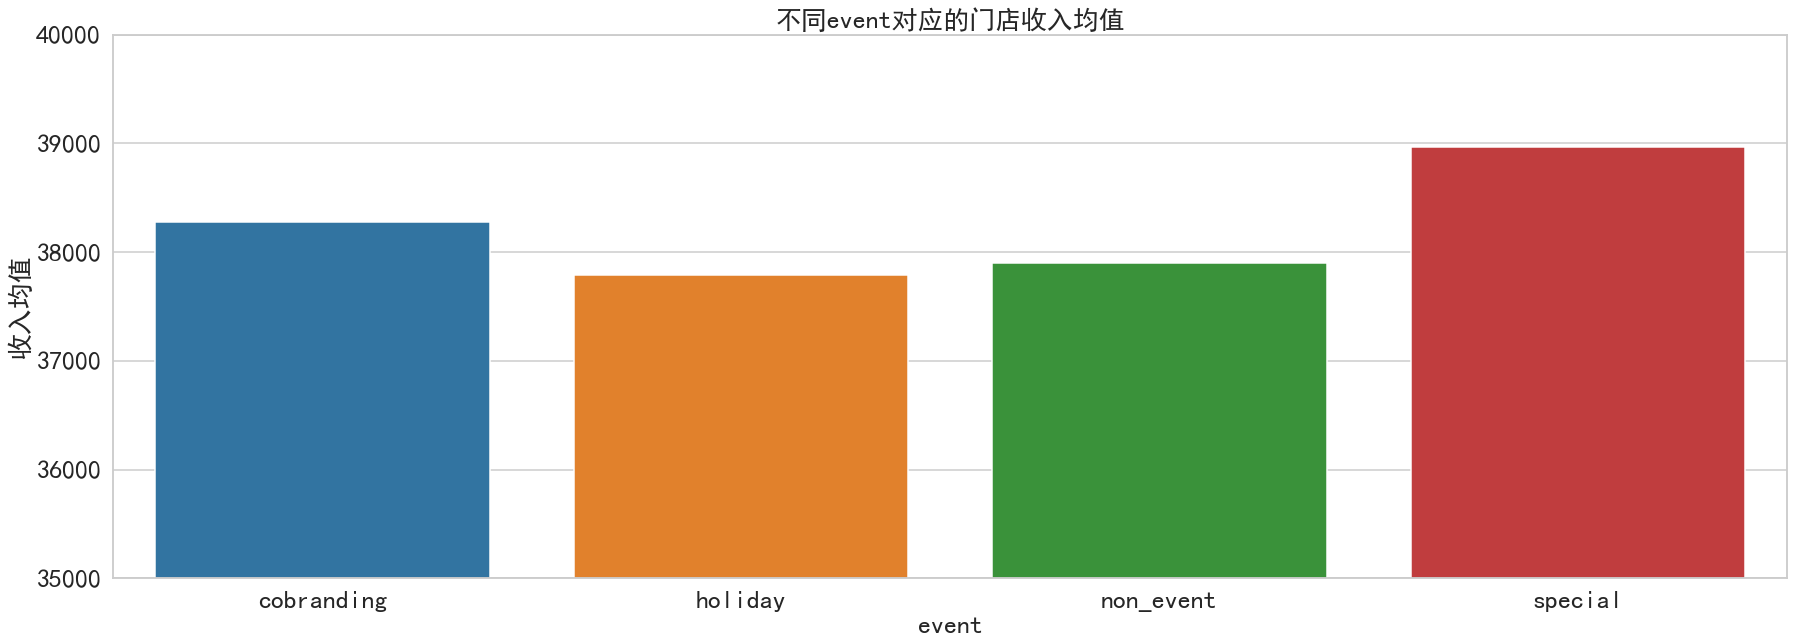

In [307]:
data_event_revenue_mean = data.groupby(['event'])['revenue'].mean().reset_index()
sns.barplot(data = data_event_revenue_mean,
           x = 'event',
           y = 'revenue')
plt.title(u'不同event对应的门店收入均值')
plt.ylabel(u'收入均值')
plt.ylim([35000,40000])
plt.show()

#### 知识1

节假日门店平均收入垫底并略低于无促销活动的情况；门店特别促销平均收入居首，相较于其余情况收入平均高出近10000。

## 微信推送次数的分布情况

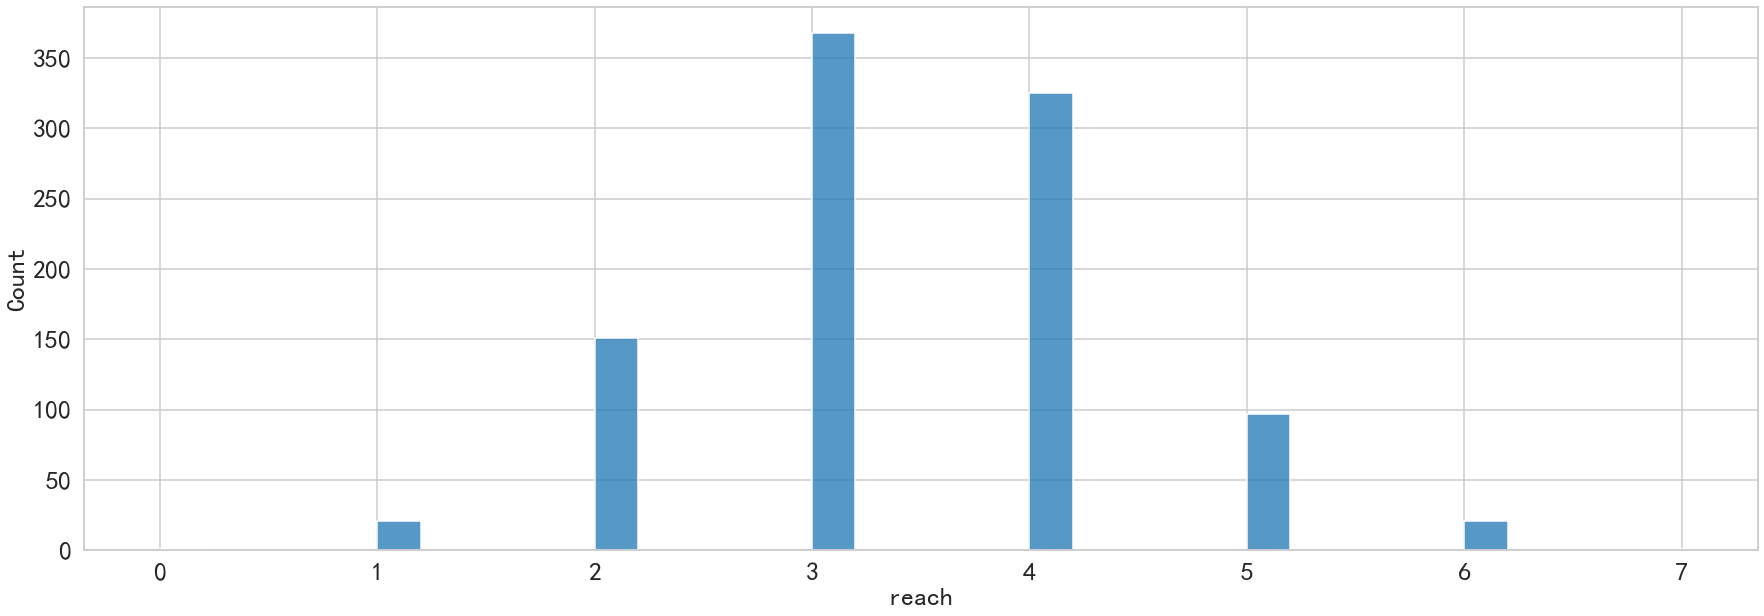

In [308]:
sns.histplot(data = data,
            x = 'reach')
plt.show()

In [309]:
data_reach_value_counts = data['reach'].value_counts().reset_index()
data_reach_value_counts['perc'] = data_reach_value_counts.reach/data_reach_value_counts.reach.sum()
data_reach_value_counts['total_perc'] = data_reach_value_counts.perc.cumsum()
data_reach_value_counts

,index,reach,perc,total_perc
0,3,368,0.373604,0.373604
1,4,325,0.329949,0.703553
2,2,151,0.153299,0.856853
3,5,97,0.098477,0.955330
4,1,21,0.021320,0.976650
5,6,21,0.021320,0.997970
6,0,1,0.001015,0.998985
7,7,1,0.001015,1.000000


#### 知识2

微信推送次数主要集中于2~4次。

## 门店促销人员投入的分布情况

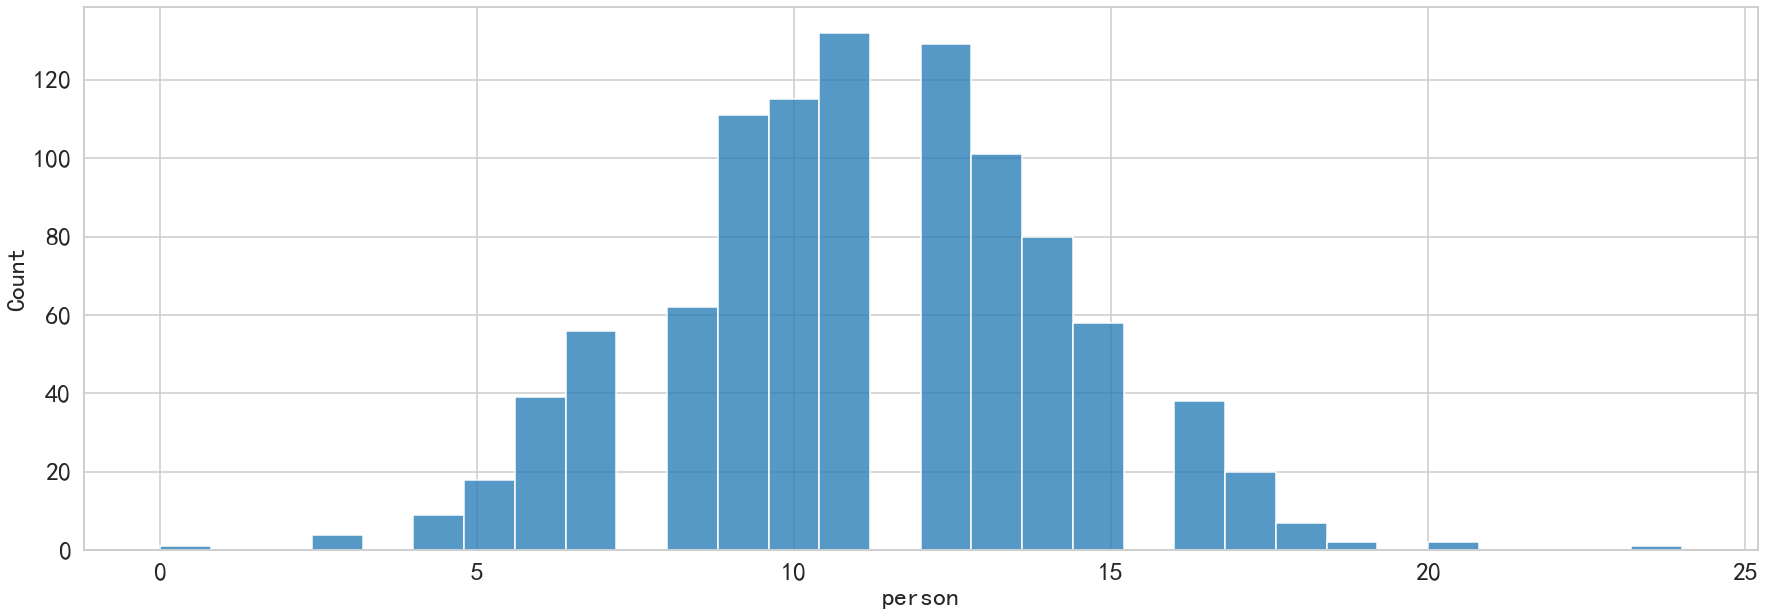

In [310]:
sns.histplot(data = data,
            x = 'person')
plt.show()

#### 知识3

门店促销人员投入数量主要集中于8~15人。

## 相关性

<ipython-input-311-0f8e1b06a19d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.array(data.corr())
<ipython-input-311-0f8e1b06a19d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data = data.corr(),mask = mask,vmax = .8,annot=True)


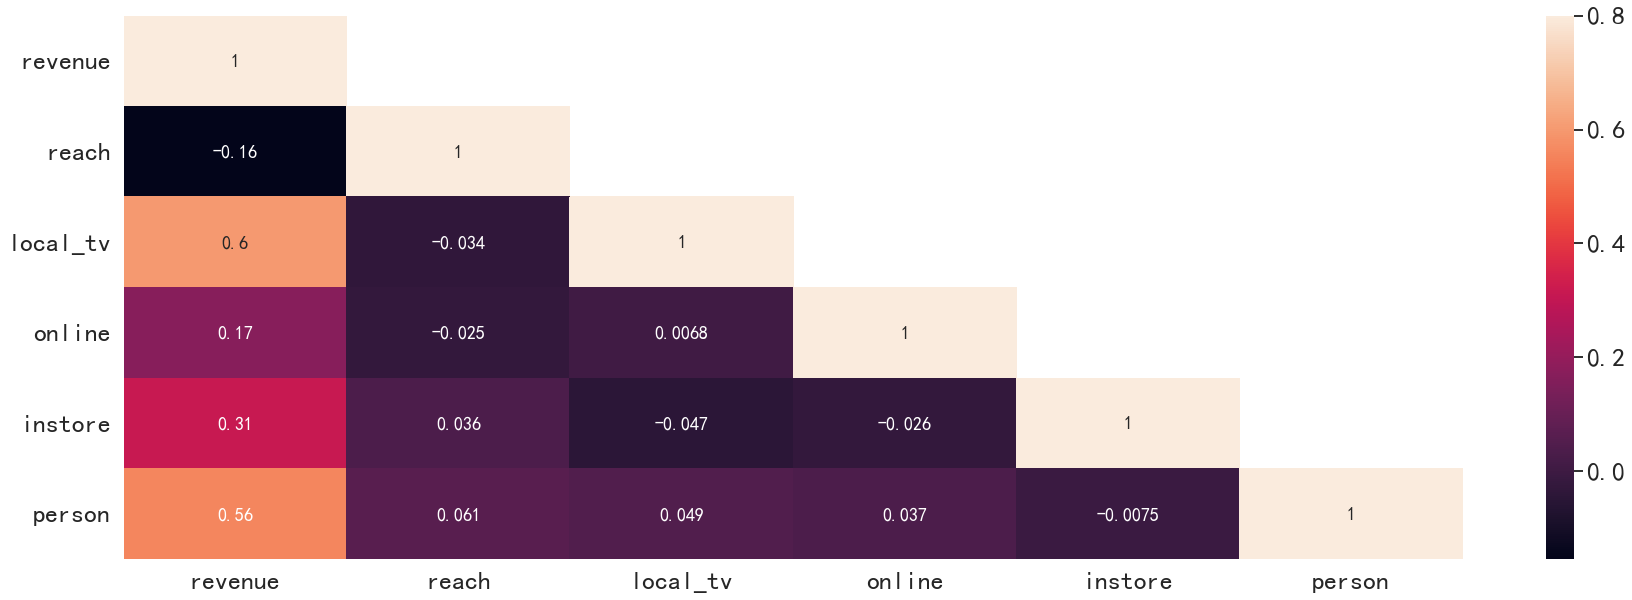

In [311]:
mask = np.array(data.corr())
mask[np.tril_indices_from(mask)] = False
sns.heatmap(data = data.corr(),mask = mask,vmax = .8,annot=True)
plt.show()

#### 知识4

相关程度的划分依据：

* r的绝对值>=0.8：强相关
* 0.5<=r的绝对值<0.8：中等程度相关
* 0.3<=r的绝对值<0.5：弱相关
* 0<=r的绝对值<0.3：不相关

1. 自变量与因变量相关性分析
    - 自变量local_tv及person与因变量revenue呈现中等程度相关
    - 自变量instore与因变量revenue呈现弱相关
    - 其余变量不相关
2. 自变量与自变量相关性分析
    - 自变量自身均未有明显的相关性

### 各种促销事件对应的数据条数

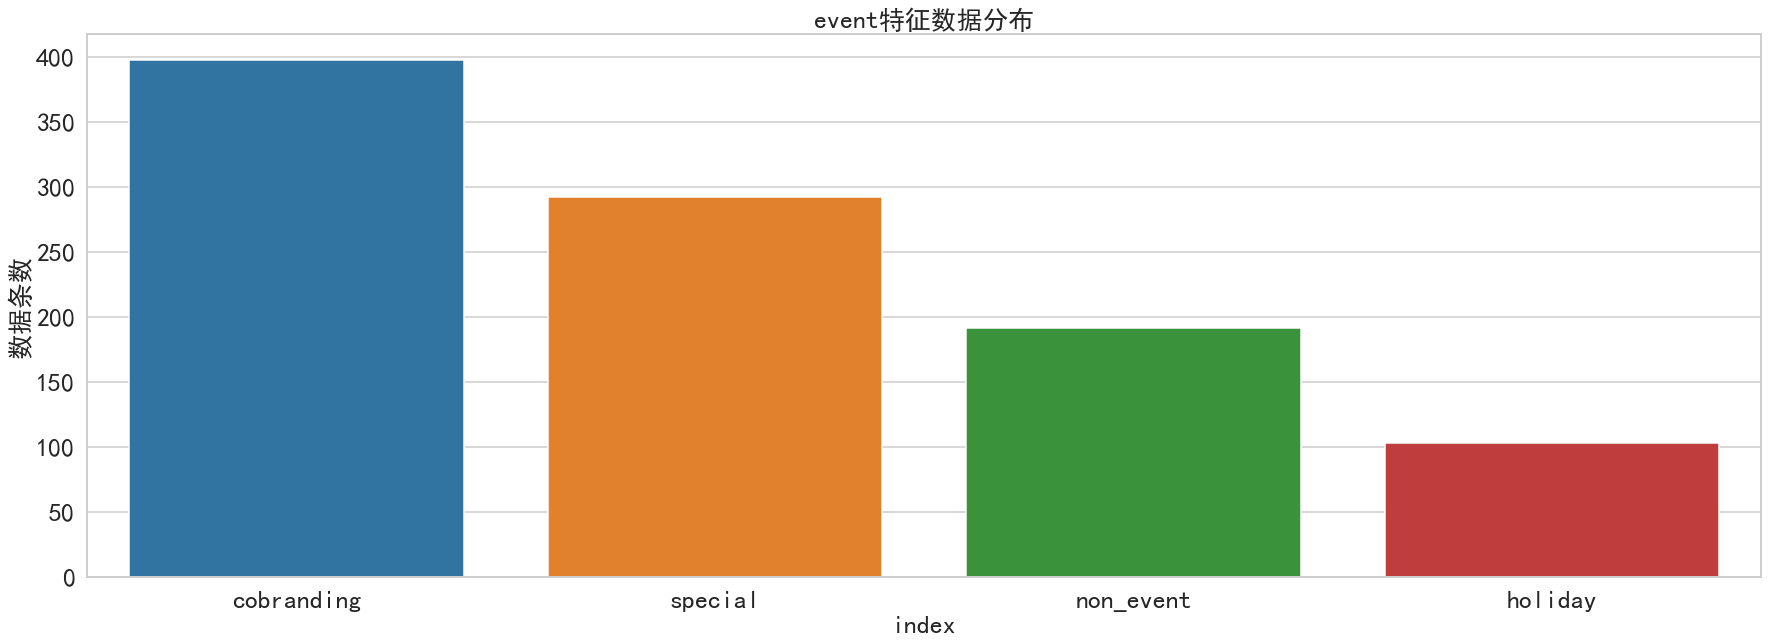

In [312]:
data_event_value_counts = data['event'].value_counts().reset_index()
sns.barplot(data = data_event_value_counts,
           x = 'index',
           y = 'event')
plt.ylabel(u'数据条数')
plt.title(u'event特征数据分布')
plt.show()

# 数据清洗及预处理

## 根据数据类型划分数据集

In [313]:
data_num = data[data.columns[:-1]]
data_num.head()

,revenue,reach,local_tv,online,instore,person
0,45860.28,2,31694.91,2115,3296,8
1,63588.23,2,35040.17,1826,2501,14
2,23272.69,4,30992.82,1851,2524,6
3,45911.23,2,29417.78,2437,3049,12
4,36644.23,2,35611.11,1122,1142,13


In [314]:
data_object = data[data.columns[-1:]]
data_object.head()

,event
0,non_event
1,special
2,special
3,special
4,cobranding


## 缺失值处理

In [315]:
from sklearn.impute import SimpleImputer
simpleImputer = SimpleImputer(strategy='median')
simpleImputer.fit(data_num)
simpleImputer.statistics_

array([3.815911e+04, 3.000000e+00, 3.110452e+04, 1.607000e+03,
       3.351000e+03, 1.100000e+01])

In [316]:
data_num.median()

revenue     38159.11
reach           3.00
local_tv    31104.52
online       1607.00
instore      3351.00
person         11.00
dtype: float64

In [317]:
data_num = pd.DataFrame(simpleImputer.transform(data_num),columns = data_num.columns)
data_num.head()

,revenue,reach,local_tv,online,instore,person
0,45860.28,2.0,31694.91,2115.0,3296.0,8.0
1,63588.23,2.0,35040.17,1826.0,2501.0,14.0
2,23272.69,4.0,30992.82,1851.0,2524.0,6.0
3,45911.23,2.0,29417.78,2437.0,3049.0,12.0
4,36644.23,2.0,35611.11,1122.0,1142.0,13.0


In [318]:
data_num.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   revenue   985 non-null    float64
 1   reach     985 non-null    float64
 2   local_tv  985 non-null    float64
 3   online    985 non-null    float64
 4   instore   985 non-null    float64
 5   person    985 non-null    float64
dtypes: float64(6)
memory usage: 46.3 KB


## 独热编码处理

In [319]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(data_object)

LabelBinarizer()

In [320]:
lb.classes_

array(['cobranding', 'holiday', 'non_event', 'special'], dtype='<U10')

In [321]:
data_object_label = pd.DataFrame(lb.transform(data_object),columns = ['event_' + item for item in lb.classes_])
data_object_label.head()

,event_cobranding,event_holiday,event_non_event,event_special
0,0,0,1,0
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,1,0,0,0


## 合并各类型数据生成新的数据集

In [322]:
data = pd.concat([data_num,data_object_label,data_object],axis=1)
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   revenue           985 non-null    float64
 1   reach             985 non-null    float64
 2   local_tv          985 non-null    float64
 3   online            985 non-null    float64
 4   instore           985 non-null    float64
 5   person            985 non-null    float64
 6   event_cobranding  985 non-null    int32  
 7   event_holiday     985 non-null    int32  
 8   event_non_event   985 non-null    int32  
 9   event_special     985 non-null    int32  
 10  event             985 non-null    object 
dtypes: float64(6), int32(4), object(1)
memory usage: 69.4+ KB


In [323]:
data.head()

,revenue,reach,local_tv,online,instore,person,event_cobranding,event_holiday,event_non_event,event_special,event
0,45860.28,2.0,31694.91,2115.0,3296.0,8.0,0,0,1,0,non_event
1,63588.23,2.0,35040.17,1826.0,2501.0,14.0,0,0,0,1,special
2,23272.69,4.0,30992.82,1851.0,2524.0,6.0,0,0,0,1,special
3,45911.23,2.0,29417.78,2437.0,3049.0,12.0,0,0,0,1,special
4,36644.23,2.0,35611.11,1122.0,1142.0,13.0,1,0,0,0,cobranding


## 拆分训练集与测试集

In [324]:
'''
# 拆分训练集和测试集
from sklearn.model_selection import train_test_split
c_x = list(data.columns)[1:]
c_y = ['revenue']
X,X_test,y,y_test = train_test_split(data[c_x],
                                    data[c_y],
                                    test_size = 0.3,
                                    random_state = 42)
# 重置训练集和测试集的index
X.reset_index(drop = True,inplace = True)
X_test.reset_index(drop = True,inplace = True)
y = y.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
'''

"\n# 拆分训练集和测试集\nfrom sklearn.model_selection import train_test_split\nc_x = list(data.columns)[1:]\nc_y = ['revenue']\nX,X_test,y,y_test = train_test_split(data[c_x],\n                                    data[c_y],\n                                    test_size = 0.3,\n                                    random_state = 42)\n# 重置训练集和测试集的index\nX.reset_index(drop = True,inplace = True)\nX_test.reset_index(drop = True,inplace = True)\ny = y.reset_index(drop = True)\ny_test = y_test.reset_index(drop = True)\n"

In [325]:
'''
X.head()
'''

'\nX.head()\n'

In [326]:
# 利用分层抽样拆分训练集与测试集
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=42)
for train_index,test_index in split.split(data,data.event):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

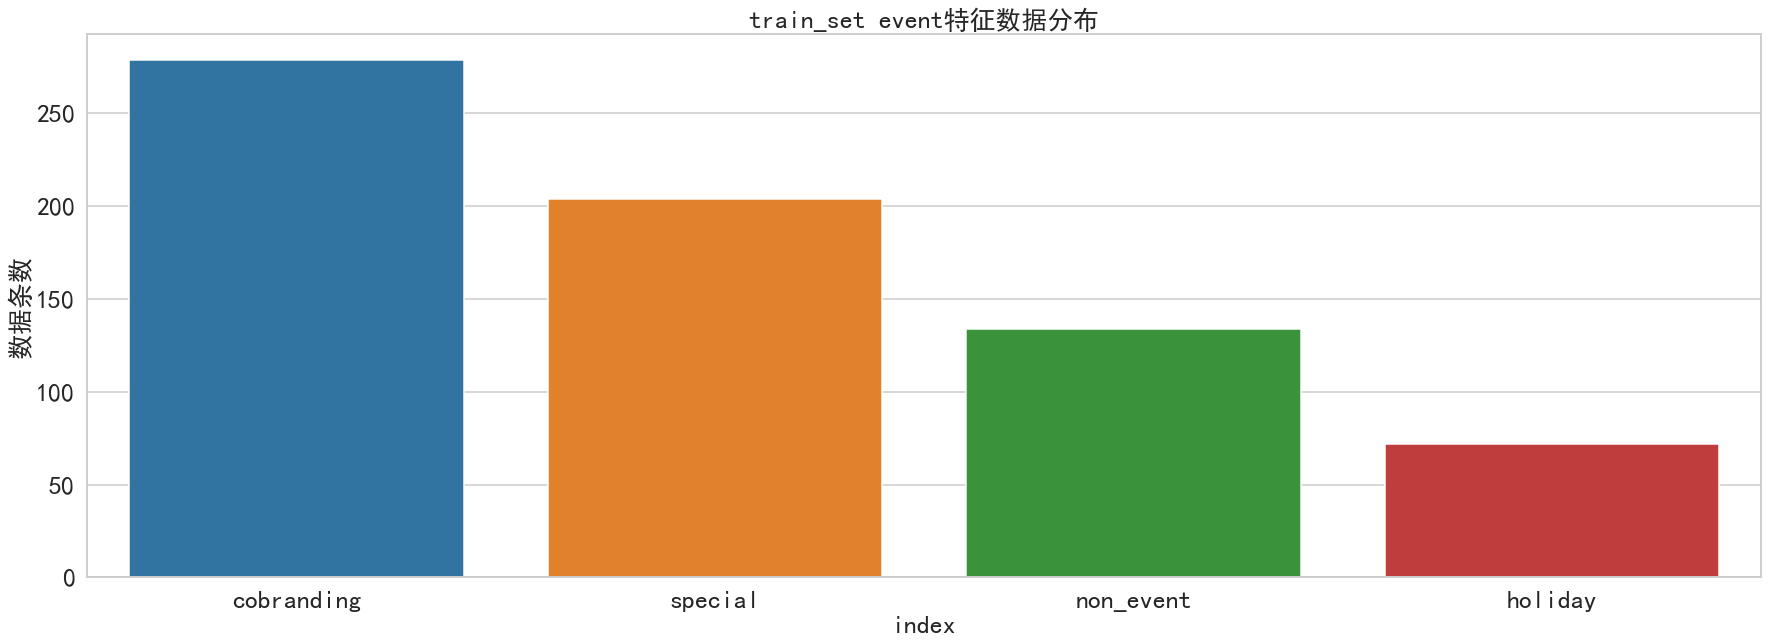

In [327]:
# 检查训练集的event数据分布情况
train_set_event_value_counts = train_set.event.value_counts().reset_index()
sns.barplot(data = train_set_event_value_counts,
           x = 'index',
           y = 'event')
plt.ylabel(u'数据条数')
plt.title(u'train_set event特征数据分布')
plt.show()

In [328]:
# 拆分训练集和测试集的自变量与因变量
X = train_set[list(train_set.columns)[1:-1]]
y = train_set['revenue']
X_test = test_set[list(test_set.columns)[1:-1]]
y_test = test_set['revenue']

# 重置X，y，X_test，y_test的index
X.reset_index(drop = True,inplace = True)
X_test.reset_index(drop = True,inplace = True)
y = y.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

## 标准化处理

In [329]:
from sklearn.preprocessing import StandardScaler
c_num = list(X.columns)[:5]
ss = StandardScaler()
ss.fit(X[c_num])

StandardScaler()

In [330]:
X_num = pd.DataFrame(ss.transform(X[c_num]),columns = c_num)
X_num.head()

,reach,local_tv,online,instore,person
0,1.545297,-0.704735,-0.466461,-0.655792,1.228454
1,0.572960,1.220328,0.645899,0.191137,-0.367934
2,-0.399378,0.742397,-1.007609,-1.600989,-0.367934
3,-0.399378,-0.975573,-0.406334,1.440256,-1.645044
4,-2.344054,0.150770,-1.973659,-0.564615,0.909177


In [331]:
# 后续使用X_tr训练数据
X_tr = pd.concat([X_num,X[X.columns[5:]]],axis = 1)
X_tr.head()

,reach,local_tv,online,instore,person,event_cobranding,event_holiday,event_non_event,event_special
0,1.545297,-0.704735,-0.466461,-0.655792,1.228454,1,0,0,0
1,0.572960,1.220328,0.645899,0.191137,-0.367934,1,0,0,0
2,-0.399378,0.742397,-1.007609,-1.600989,-0.367934,0,0,1,0
3,-0.399378,-0.975573,-0.406334,1.440256,-1.645044,0,0,0,1
4,-2.344054,0.150770,-1.973659,-0.564615,0.909177,0,0,0,1


# 训练模型

## 线性模型——线性回归

### 创建估计器

In [332]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_tr,y)

LinearRegression()

In [333]:
lr.score(X_tr,y)

0.8099095122812622

### 交叉k折验证

In [334]:
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(lr,X_tr,y,cv = 10,n_jobs = -1)

### 残差分析

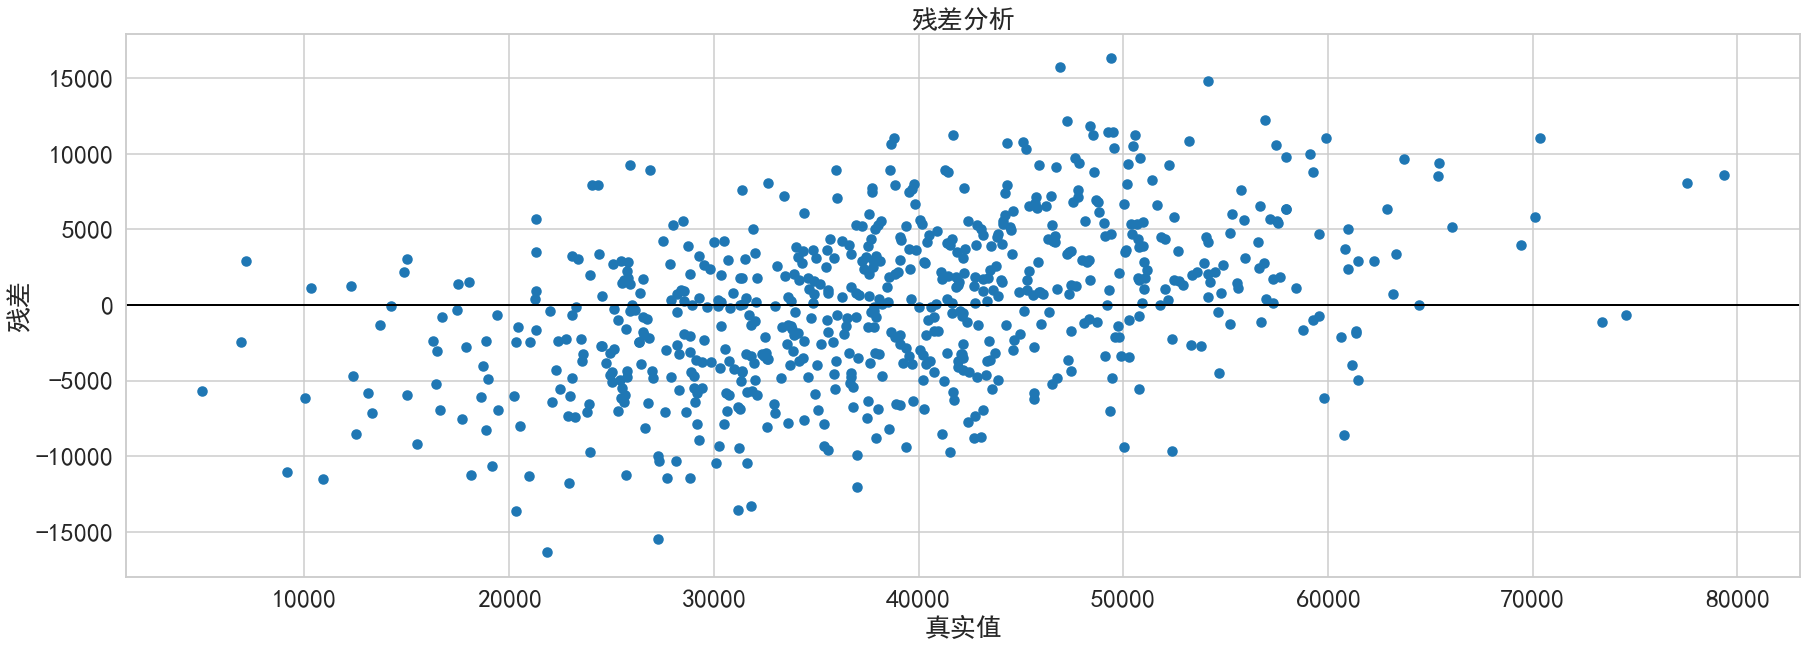

In [335]:
fig,ax = plt.subplots()
ax.scatter(y,y-predicted)
ax.axhline(lw = 2,color = 'black')
ax.set_xlabel(u'真实值')
ax.set_ylabel(u'残差')
ax.set_title(u'残差分析')
plt.show()

对于这些误差数据，我们可以进行如下的误差分析：

* 误差分布分析：我们可以计算误差的平均值、标准差和中位数等指标，来了解误差的分布情况。

* 偏差分析：我们可以观察预测值与真实值的差值，并计算偏差的平均值，来了解模型的偏差情况。如果偏差平均值较大，则可能是模型本身存在偏差，需要进行改进。

* 方差分析：我们可以计算误差的方差，来了解模型的泛化能力。如果方差较大，则可能是模型对于训练数据的拟合较差，或者对于新数据的泛化能力较差。我们可以尝试通过改变模型的超参数、增加训练数据的数量或质量来改进模型。

* 噪声分析：我们可以分析误差的原因，比如是否存在噪声干扰等因素。如果发现噪声干扰较大，则可能需要考虑增加噪声滤波器或其他干扰抑制技术来改进模型。

#### 小结

<span class="pirk">残差分布整体还是呈现出一定的线性关系（随着真实值越大，残差越大）。</span>尤其是在y的真实值低于20000时，预测值往往偏大，而在y的真实值高于60000时，预测值往往偏小。

### 交叉k折验证的$R^2$和均方误差

In [336]:
from sklearn.model_selection import cross_val_score
r2_score = cross_val_score(lr,X_tr,y,cv = 10) # 默认采用R²
mse_score = cross_val_score(lr,X_tr,y,cv = 10,scoring = 'neg_mean_squared_error')

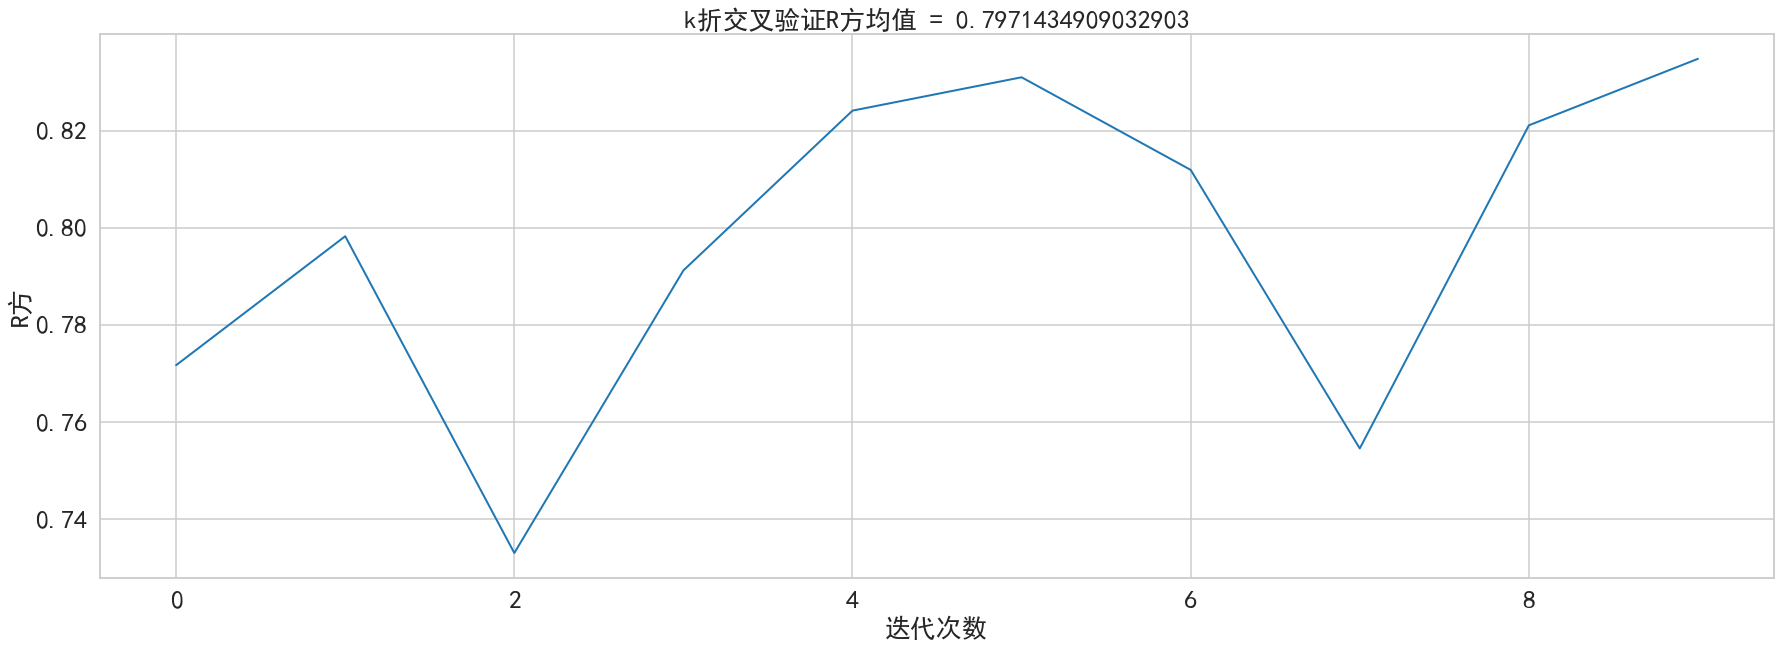

In [337]:
fig,ax = plt.subplots()
ax.plot([i for i in range(len(r2_score))],r2_score,lw = 2)
ax.set_xlabel(u'迭代次数')
ax.set_ylabel(u'R方')
ax.set_title(u'k折交叉验证R方均值 = {}'.format(r2_score.mean()))
plt.show()

In [338]:
print('R-squared:{}'.format(r2_score.mean()))
print('RMSE:{}'.format(np.sqrt(-mse_score).mean()))
print('y.mean:{}'.format(y.mean()))

R-squared:0.7971434909032903
RMSE:5271.430418835784
y.mean:38547.14985486212


In [339]:
lr.coef_

array([-2107.69648907,  6862.76692005,  1740.69332195,  4389.97298816,
        6380.03550855,   232.07767713,   337.35760952,  -130.57853177,
        -438.85675489])

## 非线性模型——决策树模型

### 创建估计器

In [340]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_tr,y)

DecisionTreeRegressor()

In [341]:
dtr.score(X_tr,y)

1.0

### 交叉k折验证

In [342]:
from sklearn.model_selection import cross_val_predict
predicted_dtr = cross_val_predict(dtr,X_tr,y,cv = 10,n_jobs=-1)

### 残差分析

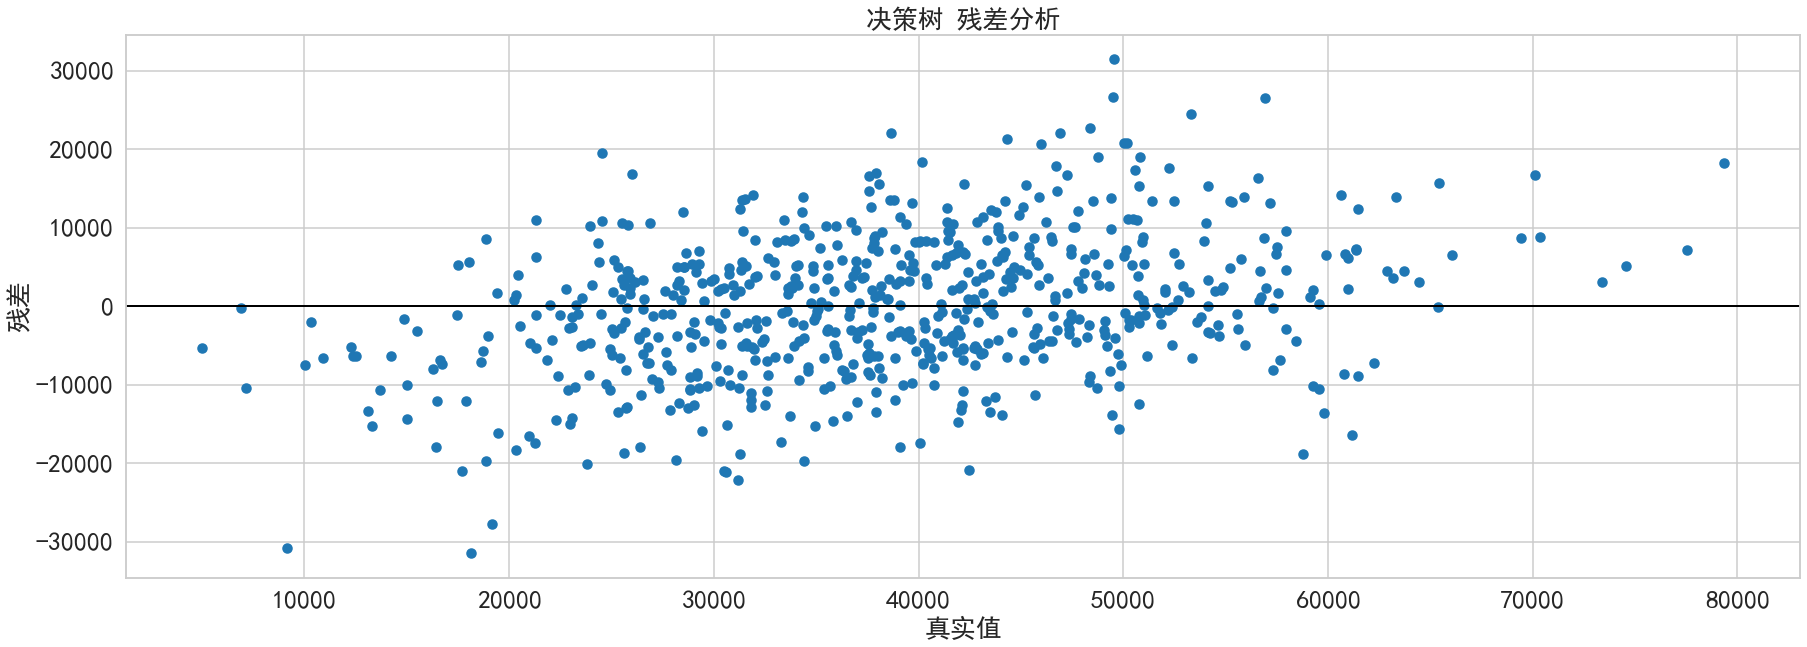

In [343]:
fig,ax = plt.subplots()
ax.scatter(y.values.reshape(-1,1),y.values.reshape(-1,1)-predicted_dtr.reshape(-1,1))
ax.axhline(lw = 2,color = 'black')
ax.set_xlabel(u'真实值')
ax.set_ylabel(u'残差')
ax.set_title(u'决策树 残差分析')
plt.show()

#### 小结

决策树残差分布情况与线性回归类似。

### 交叉k折验证的$R^2$和均方误差

In [344]:
from sklearn.model_selection import cross_val_score
r2_score_dtr = cross_val_score(dtr,X_tr,y,cv = 10)
mse_score_dtr = cross_val_score(dtr,X_tr,y,cv = 10,scoring = 'neg_mean_squared_error')

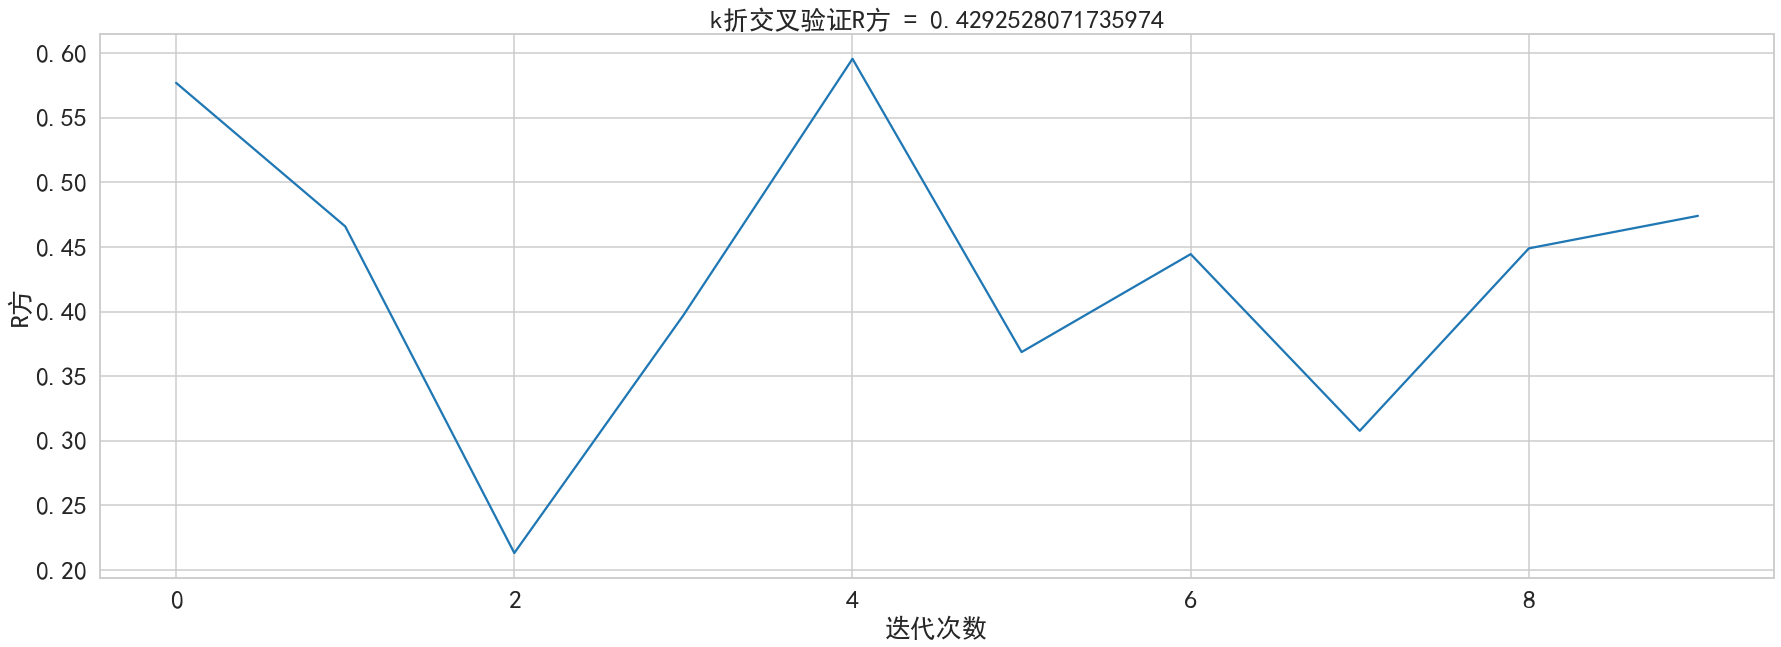

In [345]:
fig,ax = plt.subplots()
ax.plot([i for i in range(len(r2_score_dtr))],r2_score_dtr)
ax.set_xlabel(u'迭代次数')
ax.set_ylabel(u'R方')
ax.set_title(u'k折交叉验证R方 = {}'.format(r2_score_dtr.mean()))
plt.show()

In [346]:
print('R-squared:{}'.format(r2_score_dtr.mean()))
print('RMSE:{}'.format(np.sqrt(-mse_score_dtr).mean()))
print('y.mean:{}'.format(y.mean()))

R-squared:0.4292528071735974
RMSE:8849.94448023412
y.mean:38547.14985486212


## 非线性模型——随机森林模型

### 创建估计器

In [347]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100,n_jobs=-1)
rfr.fit(X_tr,y.values.ravel())

RandomForestRegressor(n_jobs=-1)

In [348]:
rfr.score(X_tr,y)

0.9606219381628143

### 交叉k折验证

In [349]:
from sklearn.model_selection import cross_val_predict
predicted_rfr = cross_val_predict(rfr,X_tr,y.values.ravel(),cv = 10,n_jobs=-1)

### 残差分析

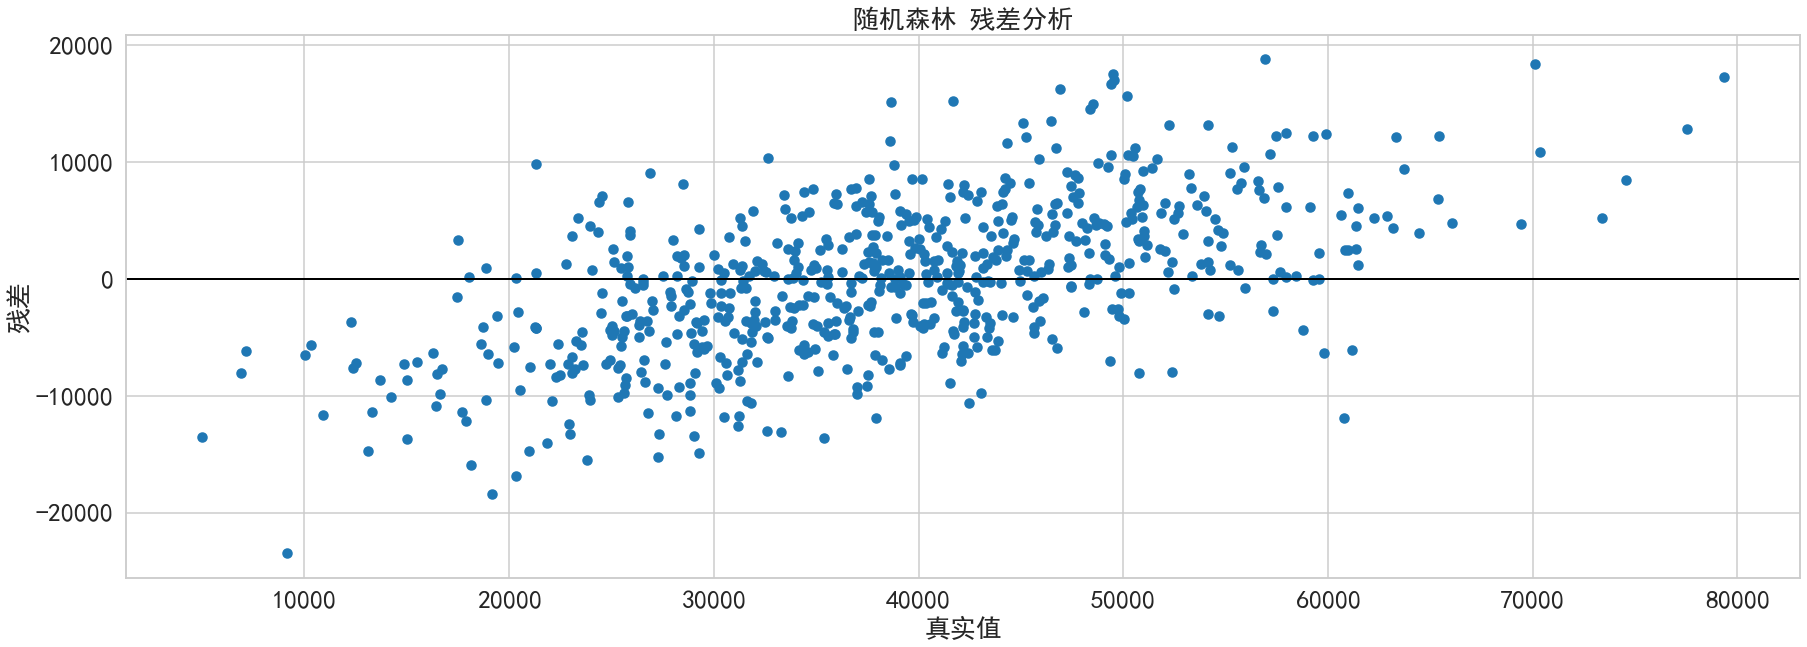

In [350]:
fig,ax = plt.subplots()
ax.scatter(y.values.reshape(-1,1),y.values.reshape(-1,1)-predicted_rfr.reshape(-1,1))
ax.axhline(lw = 2,color = 'black')
ax.set_xlabel(u'真实值')
ax.set_ylabel(u'残差')
ax.set_title(u'随机森林 残差分析')
plt.show()

#### 小结

随机森林残差分布情况与线性回归类似。

### 交叉k折验证的$R^2$和均方误差

In [351]:
from sklearn.model_selection import cross_val_score
r2_score_rfr = cross_val_score(rfr,X_tr,y.values.ravel(),cv = 10)
mse_score_rfr = cross_val_score(rfr,X_tr,y.values.ravel(),cv = 10,scoring = 'neg_mean_squared_error')

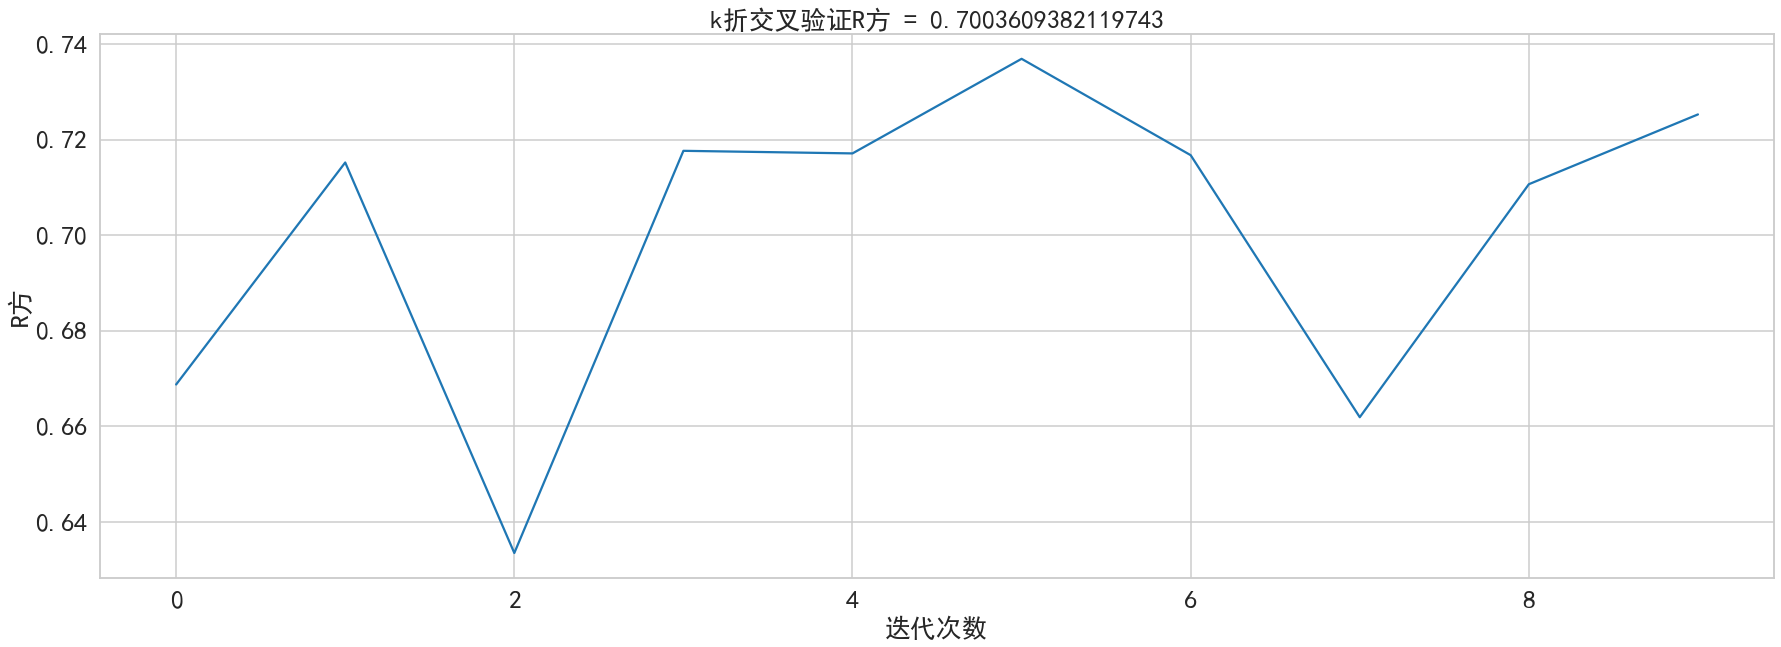

In [352]:
fig,ax = plt.subplots()
ax.plot([i for i in range(len(r2_score_rfr))],r2_score_rfr)
ax.set_xlabel(u'迭代次数')
ax.set_ylabel(u'R方')
ax.set_title(u'k折交叉验证R方 = {}'.format(r2_score_rfr.mean()))
plt.show()

In [353]:
print('R-squared:{}'.format(r2_score_rfr.mean()))
print('RMSE:{}'.format(np.sqrt(-mse_score_rfr).mean()))
print('y.mean:{}'.format(y.mean()))

R-squared:0.7003609382119743
RMSE:6424.019733681713
y.mean:38547.14985486212


## 结论

在没有设置任何超参的情况下:
1. <span class="girk">决策树</span>和<span class="girk">随机森林</span>出现<span class="girk">过拟合</span>情况。
2. 根据交叉验证集上的表现，<span class="girk">随机森林</span>模型值得<span class="girk">进一步优化</span>。

# 模型调优

## 随机森林模型调优

In [354]:
from sklearn.model_selection import GridSearchCV
n_estimators = [80,100,120] # 内含决策树数量
max_features = [5,8] # 寻找最佳分割时要考虑的特征数量
max_depth = [None] # 树的最大深度。如果为None，则展开节点，直到所有叶子都是纯的，或者直到所有叶子包含的样本少于min_samples_split。
min_samples_split = [2,5,10] # 拆分内部节点所需的最小样本数,且这个值不能小于2
max_leaf_nodes = [None] # 限制最大叶节点的数量
min_samples_leaf = [1,2] # 叶节点所需要的最小样本数

params_grid = {'n_estimators':n_estimators,
         'max_features':max_features,
         'max_depth':max_depth,
         'min_samples_split':min_samples_split,
         'min_samples_leaf':min_samples_leaf}
grid_search = GridSearchCV(rfr,params_grid,cv = 5,
                          scoring = 'neg_mean_squared_error')
grid_search.fit(X_tr,y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': [None], 'max_features': [5, 8],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [80, 100, 120]},
             scoring='neg_mean_squared_error')

In [355]:
# 最佳参数配置
grid_search.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 80}

In [356]:
# 最佳参数配置对应的模型的mse
np.sqrt(-grid_search.best_score_)

6277.635233055671

In [357]:
# 网格搜索结果根据mse升序排列前20的参数配置情况
dict_gs_cv = grid_search.cv_results_
dict_gs_cv.keys()

result_list = []
for mean_test_score,params in zip(dict_gs_cv['mean_test_score'],dict_gs_cv['params']):
    params['mean_test_score'] = round(np.sqrt(-mean_test_score),2)
    result_list.append(params)
cv_result_df = pd.DataFrame(result_list)
cv_result_df.sort_values('mean_test_score',inplace = True)
cv_result_df.head(20)

,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,mean_test_score
3,None,5,1,5,80,6277.64
2,None,5,1,2,120,6297.32
0,None,5,1,2,80,6299.30
4,None,5,1,5,100,6304.42
13,None,5,2,5,100,6312.46
11,None,5,2,2,120,6316.95
14,None,5,2,5,120,6317.13
5,None,5,1,5,120,6325.08
8,None,5,1,10,120,6328.93
10,None,5,2,2,100,6341.78


## 结论

根据目前针对随机<span class="girk">森林模型</span>的参数调优结果可知，其在交叉验证集上的表现<span class="girk">不及线性回归模型</span>，<span class="girk">不建议使用该模型进行预测行为</span>，不过在<span class="girk">产出业务相关建议时可提供一定的帮助</span>。

# 测试集表现

## 测试集自变量数据处理

In [358]:
X_test.head()

,reach,local_tv,online,instore,person,event_cobranding,event_holiday,event_non_event,event_special
0,3.0,29598.75,1641.0,2075.0,5.0,0,0,0,1
1,2.0,34892.02,1503.0,4621.0,9.0,0,0,0,1
2,4.0,30686.71,2151.0,2857.0,6.0,0,1,0,0
3,4.0,33439.71,2155.0,2449.0,16.0,0,0,1,0
4,4.0,37897.33,1624.0,2579.0,12.0,1,0,0,0


In [359]:
X_test_num = pd.DataFrame(ss.transform(X_test[c_num]),columns = c_num)
X_test_num.head()

,reach,local_tv,online,instore,person
0,-0.399378,-0.437727,0.106755,-1.275793,-1.964322
1,-1.371716,0.902701,-0.169832,1.303491,-0.687211
2,0.572960,-0.162220,1.128923,-0.483570,-1.645044
3,0.572960,0.534929,1.136940,-0.896903,1.547732
4,0.572960,1.663744,0.072682,-0.765204,0.270621


In [360]:
X_test_tr = pd.concat([X_test_num,X_test[X_test.columns[5:]]],axis = 1)
X_test_tr.head()

,reach,local_tv,online,instore,person,event_cobranding,event_holiday,event_non_event,event_special
0,-0.399378,-0.437727,0.106755,-1.275793,-1.964322,0,0,0,1
1,-1.371716,0.902701,-0.169832,1.303491,-0.687211,0,0,0,1
2,0.572960,-0.162220,1.128923,-0.483570,-1.645044,0,1,0,0
3,0.572960,0.534929,1.136940,-0.896903,1.547732,0,0,1,0
4,0.572960,1.663744,0.072682,-0.765204,0.270621,1,0,0,0


## 线性模型——线性回归

### 模型评估

In [361]:
from sklearn.metrics import mean_squared_error
y_predict = lr.predict(X_test_tr)
r2_score = lr.score(X_test_tr,y_test)
rmse_score = np.sqrt(mean_squared_error(y_test,y_predict))
print(u'R-squared:{}'.format(r2_score))
print(u'rmse_score:{}'.format(rmse_score))
print(u'y_test.mean:{}'.format(y_test.mean()))

R-squared:0.7775448697507781
rmse_score:5166.364539182938
y_test.mean:37915.56908783784


### 残差分布

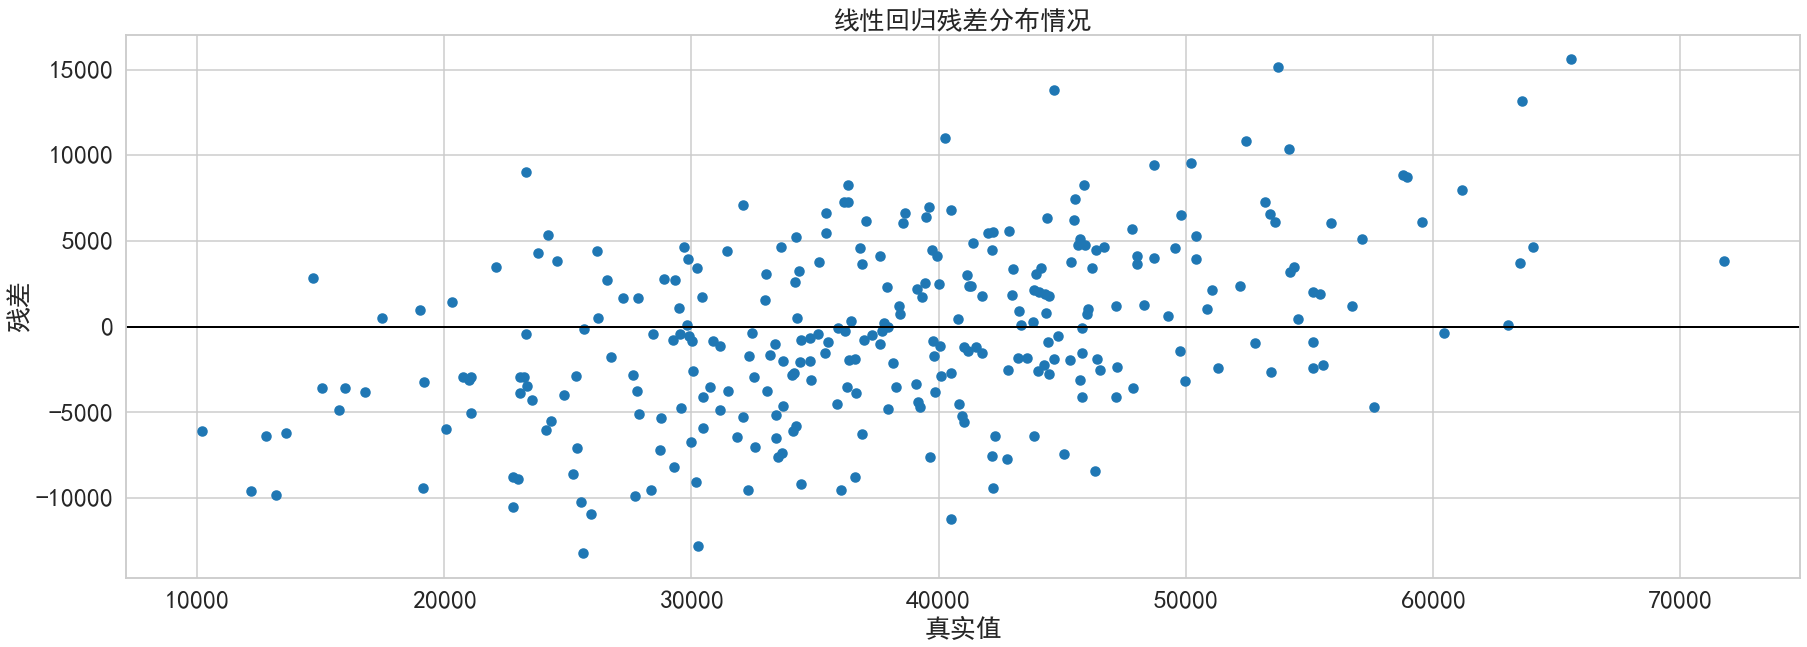

In [362]:
fig,ax = plt.subplots()
ax.scatter(y_test,y_test - y_predict)
ax.axhline(lw = 2,color = 'black')
ax.set_xlabel(u'真实值')
ax.set_ylabel(u'残差')
ax.set_title(u'线性回归残差分布情况')
plt.show()

## 非线性模型——随机森林模型

### 模型评估

In [363]:
from sklearn.metrics import mean_squared_error
best_rfr = grid_search.best_estimator_
y_predict = best_rfr.predict(X_test_tr)
r2_score = best_rfr.score(X_test_tr,y_test)
rmse_score = np.sqrt(mean_squared_error(y_test,y_predict))
print(u'R-squared:{}'.format(r2_score))
print(u'rmse_score:{}'.format(rmse_score))
print(u'y_test.mean:{}'.format(y_test.mean()))

R-squared:0.71845482988613
rmse_score:5812.16419294334
y_test.mean:37915.56908783784


### 残差分布

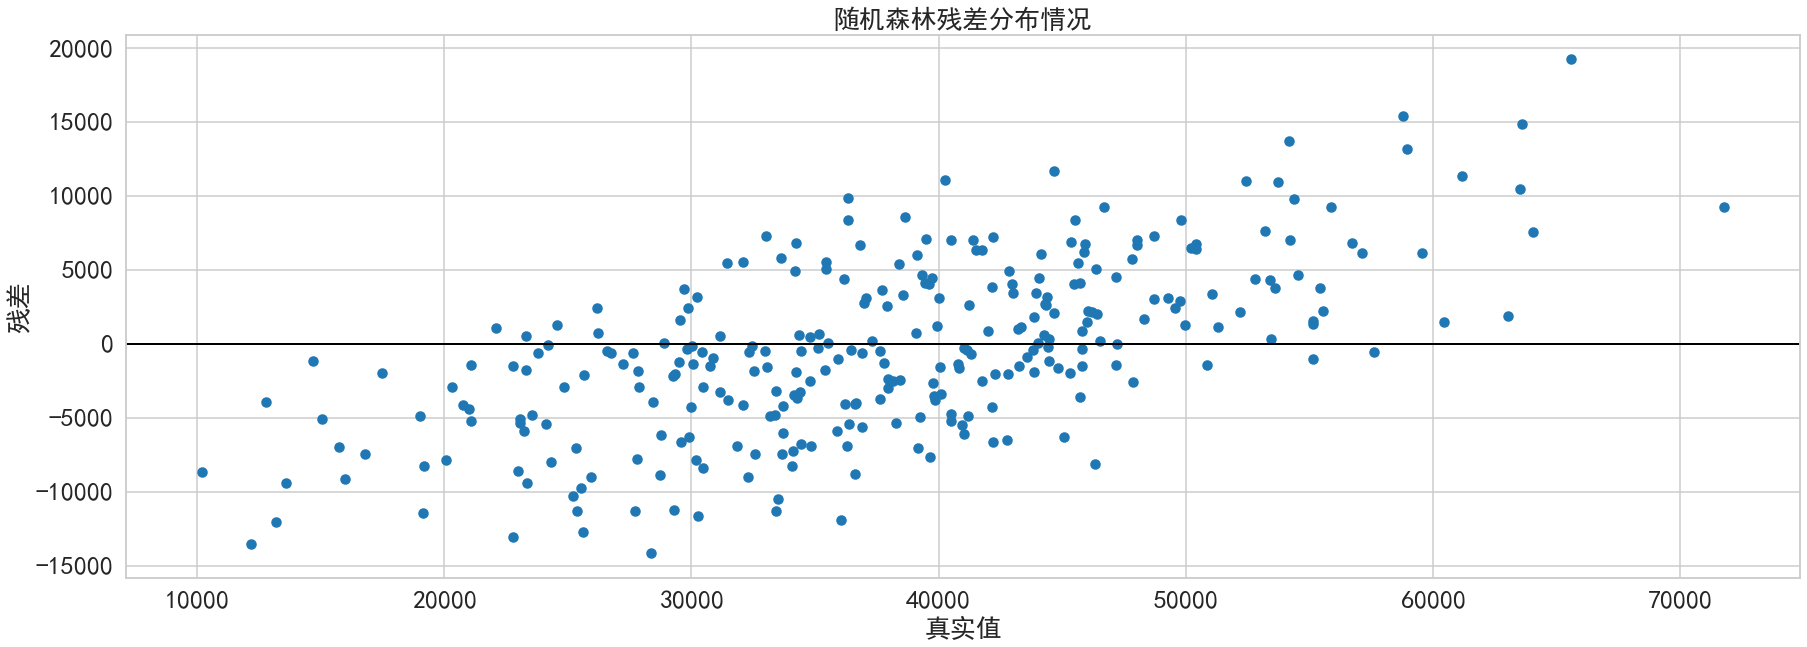

In [364]:
fig,ax = plt.subplots()
ax.scatter(y_test,y_test - y_predict)
ax.axhline(lw = 2,color = 'black')
ax.set_xlabel(u'真实值')
ax.set_ylabel(u'残差')
ax.set_title(u'随机森林残差分布情况')
plt.show()

## 结论

从测试集上的表现来说，<span class="girk">线性回归模型的模型评估分数高于随机森林</span>，符合之前的预期；对比残差分析图，可以清晰地看到<span class="girk">线性回归模型的残差分布更加均匀，趋势性不明显</span>。综上，从预测能力上来说，<span class="girk">建议使用线性回归模型</span>。

# 业务建议

In [365]:
lr_importance_dict = {'特征':X_tr.columns,
                     '系数绝对值':abs(lr.coef_)}
lr_importance_df = pd.DataFrame(lr_importance_dict)
lr_importance_df.sort_values('系数绝对值',ascending = False,inplace=True)
lr_importance_df.reset_index(drop = True,inplace = True)
lr_importance_df

,特征,系数绝对值
0,local_tv,6862.766920
1,person,6380.035509
2,instore,4389.972988
3,reach,2107.696489
4,online,1740.693322
5,event_special,438.856755
6,event_holiday,337.357610
7,event_cobranding,232.077677
8,event_non_event,130.578532


In [366]:
rfr_importance_dict = {'特征':X_tr.columns,
                     '系数绝对值':abs(best_rfr.feature_importances_)}
rfr_importance_df = pd.DataFrame(rfr_importance_dict)
rfr_importance_df.sort_values('系数绝对值',ascending = False,inplace=True)
rfr_importance_df.reset_index(drop = True,inplace = True)
rfr_importance_df

,特征,系数绝对值
0,local_tv,0.390003
1,person,0.318364
2,instore,0.161911
3,online,0.076874
4,reach,0.033164
5,event_cobranding,0.006223
6,event_special,0.006042
7,event_non_event,0.004652
8,event_holiday,0.002765


通过两个模型的系数值比较，可知<span class="girk">本地电视广告投入(loval_tv)</span>和<span class="girk">门店销售人员投入(person)</span>两个特征对门店销售额的影响程度最高，<span class="girk">门店内海报陈列等投入(instore)</span>次之。这意味着如果想提升门店的销售额，需要在这三个渠道上增加投入。